In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
%matplotlib inline

/Users/vbd402/Documents/Projects/mixedbridge


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from src.solvers.wiener_process import WienerProcess
from src.solvers.euler import Euler
from src.stochastic_processes.cell_model import CellDiffusionProcess, CellDiffusionProcessAux
from src.stochastic_processes.abstract_processes.guided_bridge_process import GuidedBridgeProcess
from src.mcmc.pcn import PreconditionedCrankNicolson

In [3]:
dim = 2
alpha = 1. / 16.
sigma = .1
T = 4.0
dt = 1./500
dtype = jnp.float32
rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.1, -0.1], dtype=dtype)

In [4]:
wiener_process = WienerProcess(dim, dtype, rng_key)
sde = CellDiffusionProcess(alpha, sigma, T=T, dt=dt)
solver = Euler(sde)

dWs = wiener_process.sample_path(sde.ts).xs
path = solver.solve(x0, dWs=dWs)

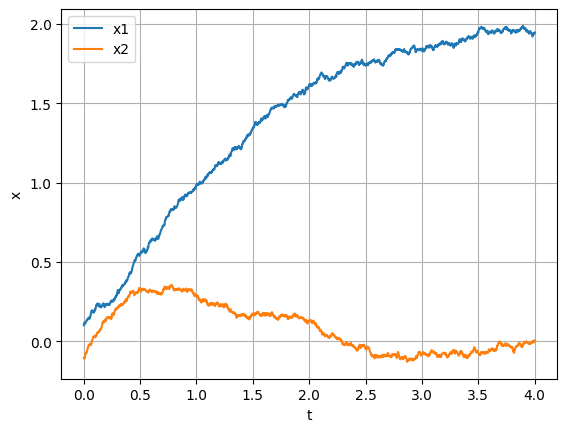

In [5]:
plt.plot(path.ts, path.xs[:, 0], label='x1')
plt.plot(path.ts, path.xs[:, 1], label='x2')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()

In [6]:
aux_sde = CellDiffusionProcessAux(alpha, sigma, T=4.0, dt=1./500.)
L0 = jnp.eye(dim, dtype=dtype)
x0 = jnp.array([0.1, -0.1], dtype=dtype)
xT = jnp.array([2.0, -0.1], dtype=dtype)
Sigma0 = jnp.eye(dim, dtype=dtype) * 1e-10
guided_sde = GuidedBridgeProcess(sde, aux_sde, L0, Sigma0, start=x0, target=xT)
solver = Euler(guided_sde)
path = solver.solve(x0, dWs=dWs)

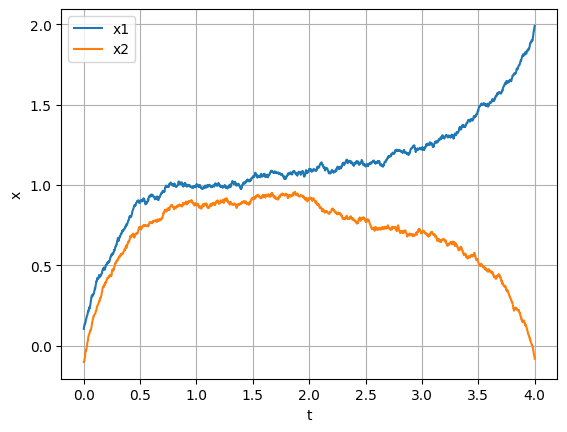

In [7]:
plt.plot(path.ts, path.xs[:, 0], label='x1')
plt.plot(path.ts, path.xs[:, 1], label='x2')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()

In [10]:
mcmc_model = PreconditionedCrankNicolson(
    rho=0.98,
    x0=x0,
    guided_process=guided_sde,
    rng_key=rng_key,
)

In [35]:
path, lls = mcmc_model.update(n_iters=1000, verbose=True, log_every=50)

Iteration 50/1000: log likelihood = 84.09127044677734, accepted = True
Iteration 100/1000: log likelihood = 98.326416015625, accepted = True
Iteration 150/1000: log likelihood = 106.0147476196289, accepted = True
Iteration 200/1000: log likelihood = 110.41253662109375, accepted = True
Iteration 250/1000: log likelihood = 109.43578338623047, accepted = True
Iteration 300/1000: log likelihood = 111.80131530761719, accepted = False
Iteration 350/1000: log likelihood = 108.55686950683594, accepted = True
Iteration 400/1000: log likelihood = 108.86346435546875, accepted = False
Iteration 450/1000: log likelihood = 104.71735382080078, accepted = True
Iteration 500/1000: log likelihood = 105.90174102783203, accepted = True
Iteration 550/1000: log likelihood = 110.98167419433594, accepted = True
Iteration 600/1000: log likelihood = 117.76428985595703, accepted = True
Iteration 650/1000: log likelihood = 120.8559799194336, accepted = True
Iteration 700/1000: log likelihood = 120.951171875, acce

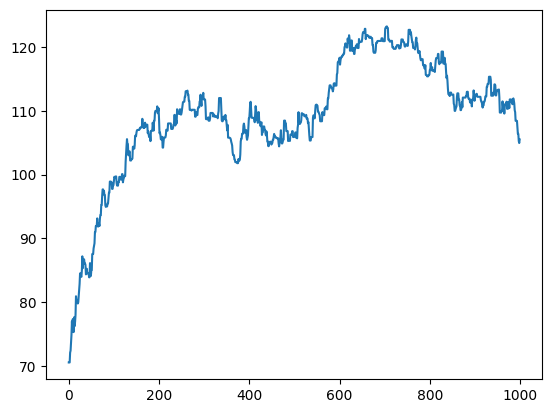

In [36]:
plt.plot(lls)

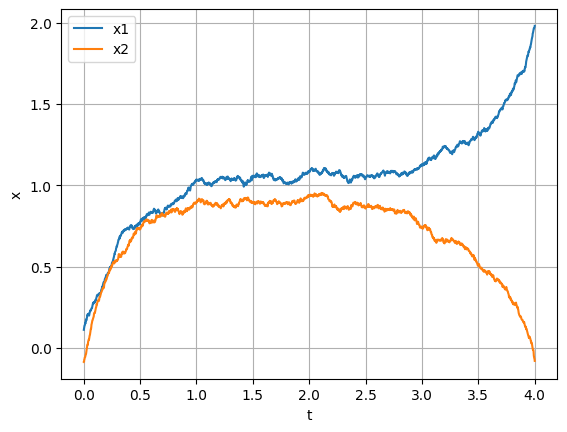

In [37]:
plt.plot(path.ts, path.xs[:, 0], label='x1')
plt.plot(path.ts, path.xs[:, 1], label='x2')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()